In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())

from func import get_data

# fix random generator seed (for reproducibility of results)
#np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Read the CSV file into a pandas DataFrame and display the first few rows
X_train,y_train,X_test,y_test,age,sfd = get_data(True,True)


print("Training Dataset size:", len(X_train))
print("Test Dataset size:", len(X_test))

print('Training data shape: ',X_train.shape)
print('Test data shape: ',X_test.shape)

ind_train = age[0].astype("int")
ind_test = age[1].astype("int")

#________________________________________________

Training Dataset size: 1025
Test Dataset size: 303
Training data shape:  (1025, 30)
Test data shape:  (303, 30)


In [2]:
def hierarchical_model(X, ind, n_cat, n_ind, obs=None):
    n_obs, n_features = X.shape

    beta = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1], n_cat), 1).to_event())    
    mu = pyro.sample("alpha_mu", dist.Normal(0., 10.).expand([n_cat]).to_event())
    sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(10.).expand([n_cat]).to_event())
    
    # i individuals
    with pyro.plate("alpha_plate", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(mu, sigma).to_event())    
        #print("aplha shape: ", alpha.shape)
        
    # Priors
    # n features
    with pyro.plate("beta_plate", n_obs):
        #print("alpha ind shape: ", alpha[ind].shape)
        #print("beta ind ", beta.shape)
        #print("shape: ", X.matmul(beta).shape)
        val = alpha[ind] + X.matmul(beta)
        pyro.sample("obs", dist.Categorical(logits=val), obs=obs)

def hierarchical_model_ARD(X, ind, n_cat, n_ind, hyp_param, obs=None):
    n_obs, n_features = X.shape
    #print(X.shape)
    a = pyro.sample("a", dist.Gamma(hyp_param[0]*torch.ones(X.shape[1], 1), hyp_param[1]*torch.ones(X.shape[1], 1)).to_event())
    #print('a shape ', a.shape)

    beta = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1], n_cat), a).to_event())    
    #print('beta shape ', beta.shape)

    mu = pyro.sample("alpha_mu", dist.Normal(0., hyp_param[2]).expand([n_cat]).to_event())
    sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(hyp_param[3]).expand([n_cat]).to_event())
    
    # i individuals
    with pyro.plate("alpha_plate", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(mu, sigma).to_event())
        #print("aplha shape: ", alpha.shape)
        
    # Priors
    # n features
    with pyro.plate("beta_plate", n_obs):
        val = alpha[ind] + X.matmul(beta)
        #print("val shape: ", val.shape)
        pyro.sample("obs", dist.Categorical(logits=val), obs=obs)



In [3]:
# Prepare data for Pyro model
n_cat = int(y_train.max())
#print('n_cat', n_cat)
n_ind = ind_train.max()
#print('n_ind', n_ind)
X_train_tensor = torch.tensor(X_train.astype('float')).float()
y_train_tensor = torch.tensor(y_train).float()
#print(y_train_tensor)
ind_train = torch.tensor(ind_train) # these are indices, therefore they need to be (long) integers

model = hierarchical_model

# Define guide function
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 7000

hyp_param = [1,1,10,10]

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, ind_train-1, n_cat+1, n_ind, y_train_tensor)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 3743.2
[500] ELBO: 1010.1
[1000] ELBO: 628.8
[1500] ELBO: 541.3
[2000] ELBO: 518.7
[2500] ELBO: 487.4
[3000] ELBO: 502.4
[3500] ELBO: 525.2
[4000] ELBO: 497.4
[4500] ELBO: 465.7
[5000] ELBO: 449.2
[5500] ELBO: 465.0
[6000] ELBO: 456.3
[6500] ELBO: 451.7


In [4]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=4000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train_tensor, ind_train-1, n_cat+1, n_ind, y_train_tensor)

beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

# extract expected values of the parameters

alpha_hat = alpha_samples.mean(axis=0)
beta_hat = beta_samples.squeeze().mean(axis=0)


# make predictions for test set
y_hat = alpha_hat[ind_test-1,:] + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
# print("predictions:", y_hat-1)
# print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat-1 == y_test) / len(y_test))

Accuracy: 0.9042904290429042


In [6]:
#a_samples = samples["a"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

In [ ]:
print(beta_samples)

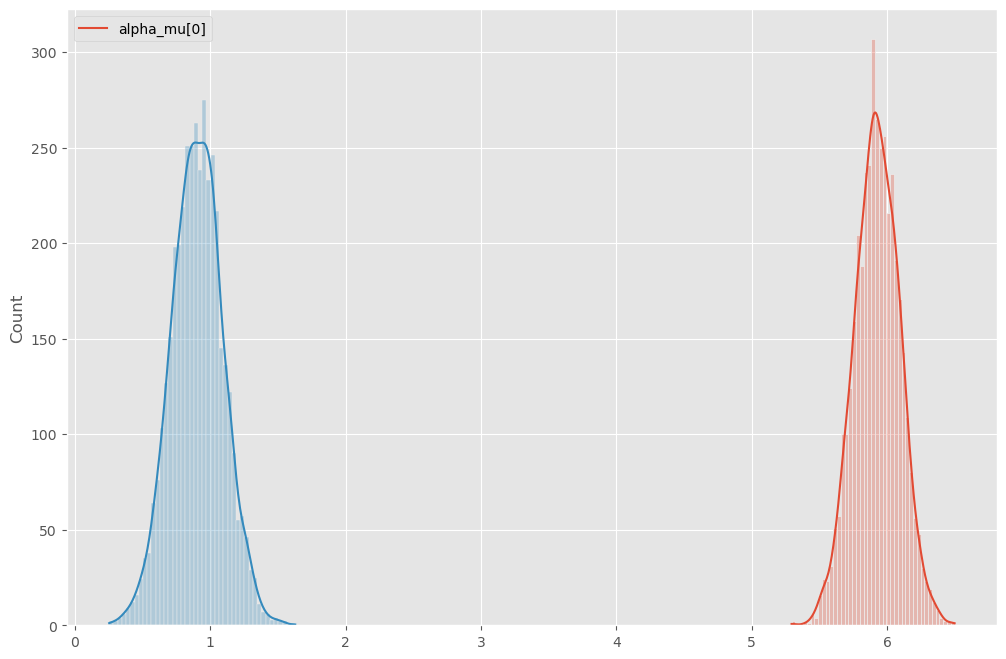

In [7]:
for c in range(n_cat+1):
    sns.histplot(alpha_mu_samples[:,0,c], kde=True, alpha=0.3)
plt.legend(["alpha_mu[%d]" % c for c in range(n_cat)])
plt.show()

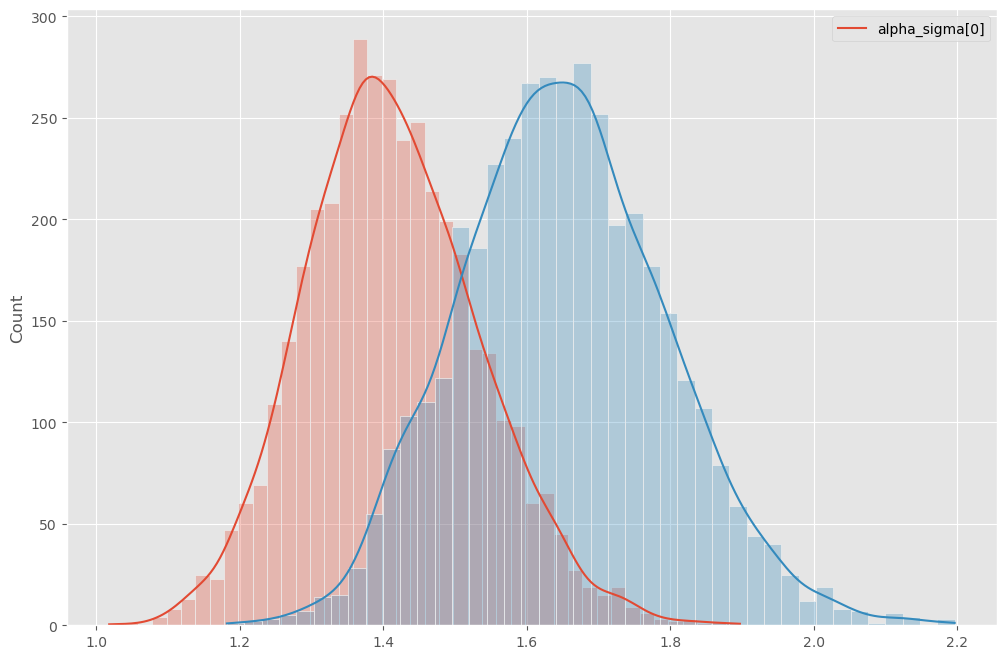

In [8]:
for c in range(n_cat+1):
    sns.histplot(alpha_sigma_samples[:,0,c], kde=True, alpha=0.3)
plt.legend(["alpha_sigma[%d]" % c for c in range(n_cat)])
plt.show()

In [9]:
# extract expected values of the parameters
alpha_hat = alpha_samples.mean(axis=0)
beta_hat = beta_samples.squeeze().mean(axis=0)

In [10]:
# make predictions for test set
y_hat = alpha_hat[ind_test-1,:] + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat-1)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat-1 == y_test) / len(y_test))

predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 1]
true values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0